# Image recognision

Unzip the dataset file

In [8]:
!unzip /content/drive/MyDrive/ColabNotebooks/archive.zip -d /content/drive/MyDrive/ColabNotebooks/

Archive:  /content/drive/MyDrive/ColabNotebooks/archive.zip
replace /content/drive/MyDrive/ColabNotebooks/Indian-Traffic Sign-Dataset/Images/0/0_original_43.png_592b345c-34ee-4cc5-b2f4-774db9375ab8.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Import Necessary Libraries**

This cell imports the required libraries for image processing, data augmentation, model building, and plotting.


In [1]:
!pip install tensorflow  # Ensure TensorFlow is installed

import numpy as np
import matplotlib.pyplot as plt

# Import from tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd



**Define Constants and Load Dataset**

This section defines constants like the dataset path and image dimensions, and loads the dataset from the specified folder, organizing images and their corresponding labels.

In [2]:
path = "/content/drive/MyDrive/ColabNotebooks/Indian-Traffic Sign-Dataset/Images"
labelFile = '/content/drive/MyDrive/ColabNotebooks/Indian-Traffic Sign-Dataset/traffic_sign.csv'
batch_size_val = 32
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes...")

for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")

images = np.array(images)
classNo = np.array(classNo)


Total Classes Detected: 58
Importing Classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57  


**Split the Dataset**

This splits the dataset into training, validation, and test sets, ensuring that the model has a dedicated portion of data for training and testing.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

print("Data Shapes")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_validation.shape, y_validation.shape)
print("Test:", X_test.shape, y_test.shape)


Data Shapes
Train: (8940, 32, 32, 3) (8940,)
Validation: (2236, 32, 32, 3) (2236,)
Test: (2795, 32, 32, 3) (2795,)


**Read Label File and Define Preprocessing Functions**

This part reads the CSV file containing class labels, and defines basic preprocessing functions that convert images to grayscale, equalize them, and normalize their pixel values.


In [4]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Reshape to add a single channel for grayscale
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


data shape  (58, 2) <class 'pandas.core.frame.DataFrame'>


**Data Augmentation**

Here, data augmentation is applied to the training set using ImageDataGenerator, generating new images with random transformations like shifts, rotations, and zooms to improve the model’s generalization.

In [5]:
dataGen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
dataGen.fit(X_train)

batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)


**Convert Labels to Categorical and Define Model Architecture**

The class labels are converted to a categorical format. Then, the model architecture is defined with several convolutional layers, max-pooling layers, and fully connected layers for classification.

In [6]:

y_train = to_categorical(y_train, num_classes=noOfClasses)
y_validation = to_categorical(y_validation, num_classes=noOfClasses)
y_test = to_categorical(y_test, num_classes=noOfClasses)

def myModel():
    model = Sequential()
    # First convolutional layer with input shape matching grayscale images
    model.add(Conv2D(60, (5, 5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Flatten the feature maps
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))  # Output layer with 'noOfClasses' nodes

    # Compile the model using 'learning_rate' instead of 'lr'
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = myModel()
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 58)                  │          29,058 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385,538 (1.47 MB)

 Trainable params: 385,538 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

None


**Train the Model**

The model is trained using the augmented dataset and validated against the validation set over a specified number of epochs.

In [7]:
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=32),  # Data generator
    steps_per_epoch=len(X_train) // 32,            # Steps per epoch
    epochs=epochs_val,                             # Number of epochs
    validation_data=(X_validation, y_validation),  # Validation data
    shuffle=True                                   # Shuffle data
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


279/279 ━━━━━━━━━━━━━━━━━━━━ 111s 390ms/step - accuracy: 0.0720 - loss: 3.8635 - val_accuracy: 0.3497 - val_loss: 2.3327
Epoch 2/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 1:22 295ms/step - accuracy: 0.2188 - loss: 2.9766

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2188 - loss: 2.9766 - val_accuracy: 0.3591 - val_loss: 2.2872
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 135s 388ms/step - accuracy: 0.2620 - loss: 2.7238 - val_accuracy: 0.5389 - val_loss: 1.6575
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5312 - loss: 2.0589 - val_accuracy: 0.5505 - val_loss: 1.6332
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 142s 408ms/step - accuracy: 0.3964 - loss: 2.1588 - val_accuracy: 0.6619 - val_loss: 1.2469
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5000 - loss: 1.9183 - val_accuracy: 0.6655 - val_loss: 1.2367
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 125s 377ms/step - accuracy: 0.4716 - loss: 1.8444 - val_accuracy: 0.7227 - val_loss: 0.9697
Epoch 8/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5625 - loss: 1.2603 - val_accuracy: 0.7030 - val_loss: 0.9934
Epoch 9/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 135s 377ms/step - accuracy: 0.5264 - loss: 1.5823 - val_acc

**Plot Training History**

This plots the loss and accuracy values for both training and validation sets to visually track the model’s performance over time.

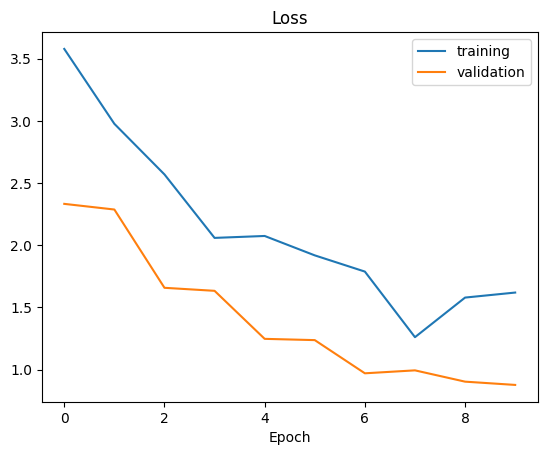

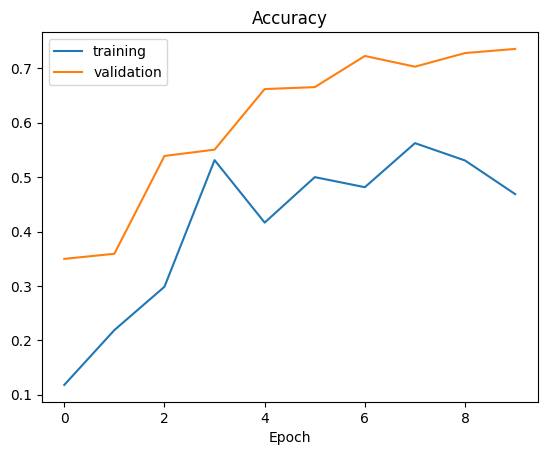

In [8]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

plt.show()


**Evaluate the Model and Save It**

This evaluates the model on the test data, printing the test loss and accuracy. The trained model is saved as a .h5 file for future use.

In [9]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

model.save("/content/drive/MyDrive/ColabNotebooks/model.h5")


Test Score: 0.8635067939758301
Test Accuracy: 0.7345259189605713
